#### Logo BG 0418 variations

First

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as image
from numpy.random import random_integers as rand
import numpy as np

In [76]:
'''
Image saver. Put any matrix in, and it will be saved as a PNG image.
It looks exactly the same as if it's plotted.
Do not put a default filename in!
'''
def savePattern(filename_, imgmatrix_, dpi_=100, cmap_=plt.cm.binary):
    image.imsave(fname=filename_, arr=imgmatrix_, dpi=dpi_, cmap=cmap_)
    



In [4]:
'''
Element is just a position handling class.
    - setPosition() sets the position directly
    - move() adds the given matrix or coordinates
'''
class Element:
    position=np.matrix([0,0])
    def __init__(self, x_=0, y_=0):
        self.setPosition(x_, y_)
        
    def setPosition(self, x_=0, y_=0):
        position=np.matrix([x_,y_])
        
    def move(self, x_, y_):
        position+=np.matrix([x_, y_])
        
    def move(self, operand):
        position+=operand

In [62]:
class Node(Element):
    #position is for the node's position in the final image
    position = np.matrix([0,0])
    #token is a set of available branches that a node can put (obvi: in our case it can't be more than 3)
    token=2
    #freePoints are for listing the checked positions where the node can put another node (branch)
    freePoints=[]
    #you can specify a bias that can modify the shape of the tree
    #bias[up,right,down,left]
    bias=[]
    
    def __init__(self, position_=0, bias_=[30,1,1,1]):
        self.position = position_
        self.bias=bias_
        self.token=2
        
    '''
    Check if got any places around in orthogonal edges of nodeArea.
    nodeArea is a StartingNest.nodeArea * StartingNest.nodeArea shaped matrix around the node.
    '''
    def checkNeighbour(self, nodeArea=0):
        #get the center point
        centerX = nodeArea.shape[0]//2
        centerY = nodeArea.shape[1]//2
        #check the free points
        #collect them into self.freePoints array
        #flushing the freePoints list
        self.freePoints=[]
        #checking the upper section
        #print("------------------------")
        #print("area:")
        #print(nodeArea)
        
        #checking the top section
        if np.count_nonzero(nodeArea[0:centerX, centerY])==0:
            #print("up ok")
            freePoint = [0, centerY]
            self.freePoints.append('u')
        #print("found branch values on up: ", np.count_nonzero(nodeArea[0:centerX, centerY]))
        
        #checking the right section
        if np.count_nonzero(nodeArea[centerX, (centerY+1):nodeArea.shape[1]])==0:
            #print("right ok")
            freePoint = [centerX, nodeArea.shape[1]]
            self.freePoints.append('r')
        #print("found branch values on right: ", np.count_nonzero(nodeArea[centerX, (centerY+1):nodeArea.shape[1]]))
        
        #checking the bottom section
        if np.count_nonzero(nodeArea[(centerX+1):nodeArea.shape[0], centerY])==0:
            #print("bottom ok")
            freePoint = [nodeArea.shape[0], centerY]
            self.freePoints.append('d')
        #print("found branch values on bottom: ", np.count_nonzero(nodeArea[(centerX+1):nodeArea.shape[0], centerY]))
        
        #checking the LEFT WING <plays proud russian hardtechno>
        if np.count_nonzero(nodeArea[centerX, 0:centerY])==0:
            #print("left ok")
            freePoint = [centerX, 0]
            self.freePoints.append('l')
        #print("found branch values on left: ", np.count_nonzero(nodeArea[centerX, 0:centerY]))
        return len(self.freePoints)
        
    def putNode(self, nodeArea, nest):
        #choose a freePoint from self.freePoints
        
        #newNodePosition=self.doArbitratedBranch(nodeArea, nest)
        newNodePosition=self.doArbitratedBranch(nodeArea, nest)

        #put a node and draw the line
        #print("actual position:", self.position)
        #print("chosen position:", newNodePosition)
        self.drawBranch(newNodePosition, nest)
        nest.addNode(newNodePosition)
        return 0
    
    def doArbitratedBranch(self, nodeArea, nest):
        newNodePosition=[]
        match=0
        while match==0:
            direction = self.getFreePointByBias()
            if direction == 0 and np.count_nonzero(np.isin(self.freePoints, 'u')):
                newNodePosition=[self.position[0,0]-(nodeArea.shape[0]//2),self.position[0,1]]
                match=1

            if direction == 1 and np.count_nonzero(np.isin(self.freePoints, 'r')):
                newNodePosition=[self.position[0,0],self.position[0,1]+(nodeArea.shape[1]//2)]
                match=1

            if direction == 2 and np.count_nonzero(np.isin(self.freePoints, 'd')):
                newNodePosition=[self.position[0,0]+(nodeArea.shape[0]//2),self.position[0,1]]
                match=1

            if direction == 3 and np.count_nonzero(np.isin(self.freePoints, 'l')):
                newNodePosition=[self.position[0,0],self.position[0,1]-(nodeArea.shape[1]//2)]
                match=1
        return newNodePosition
    
    def doUnArbitratedBranch(self, nodeArea, nest):
        newNodePosition=[]
        direction = self.getFreePointByBias()
        if direction == 0 and np.count_nonzero(np.isin(self.freePoints, 'u')):
            newNodePosition=[self.position[0,0]-(nodeArea.shape[0]//2),self.position[0,1]]

        if direction == 1 and np.count_nonzero(np.isin(self.freePoints, 'r')):
            newNodePosition=[self.position[0,0],self.position[0,1]+(nodeArea.shape[1]//2)]

        if direction == 2 and np.count_nonzero(np.isin(self.freePoints, 'd')):
            newNodePosition=[self.position[0,0]+(nodeArea.shape[0]//2),self.position[0,1]]

        if direction == 3 and np.count_nonzero(np.isin(self.freePoints, 'l')):
            newNodePosition=[self.position[0,0],self.position[0,1]-(nodeArea.shape[1]//2)]
        return newNodePosition
    
    def drawBranch(self, newPosition, nest):
        if len(newPosition)>0:
            if newPosition[0]>self.position[0,0]:
                lowerX=self.position[0,0]
                higherX=newPosition[0]
            else:
                lowerX=newPosition[0]
                higherX=self.position[0,0]
            if newPosition[0]==self.position[0,0]:
                lowerX=newPosition[0]
                higherX=self.position[0,0]+1

            if newPosition[1]>self.position[0,1]:
                lowerY=self.position[0,1]
                higherY=newPosition[1]
            else:
                lowerY=newPosition[1]
                higherY=self.position[0,1]
            if newPosition[1]==self.position[0,1]:
                lowerY=newPosition[1]
                higherY=self.position[0,1]+1

            if newPosition[0]<nest.area.shape[0] and newPosition[1]<nest.area.shape[1]:
                nest.area[newPosition[0], newPosition[1]] = nest.iterations
                nest.area[lowerX:higherX, lowerY:higherY] = nest.iterations
        
        return 0
    
    def getFreePointByBias(self):
        direction=[]
        #to up
        direction.append(np.random.rand(1)*self.bias[0])
        #to right
        direction.append(np.random.rand(1)*self.bias[1])
        #to down
        direction.append(np.random.rand(1)*self.bias[2])
        #to the dreamland
        direction.append(np.random.rand(1)*self.bias[3])
        return np.argmax(direction)
        
    def step(self, nodeArea, nest):
        if self.position[0,0]>nest.nodeArea and self.position[0,0]<nest.area.shape[0]-nest.nodeArea\
            and self.position[0,1]>nest.nodeArea and self.position[0,1]<nest.area.shape[1]-nest.nodeArea :
            freePoints = self.checkNeighbour(nodeArea)
            if self.token>0 and freePoints>0:
                self.token-=1
                self.putNode(nodeArea, nest)
        else:
            self.token=0
            

In [80]:
'''
StartingNest is a class for start several StartingNode-s.
    - startingPositionMatrix : where the first nodes are
    - nodeArea : checked area on any node steps. it puts a new node on the edge of it.
                 it has to be an odd number!
    - 
'''

class StartingNest(Element):
    startingPositionMatrix=np.matrix([[0,1,0],[1,0,1],[0,1,0]])
    nodeArea=5
    nodes=[]
    iterations=10
    area=np.zeros([1,1])
    
    def __init__(self, startingPositionMatrix_, nodeArea_=5, areaX_=100, areaY_=100, iterations=10):
        self.startingPositionMatrix=startingPositionMatrix_
        self.nodeArea=nodeArea_
        self.area=np.zeros([areaX_, areaY_])
        self.iterations=iterations
        self.setInitialNodes()
    
    def setInitialNodes(self):
        centerX = self.area.shape[0]//2 - self.startingPositionMatrix.shape[0]//2
        centerY = self.area.shape[1]//2 - self.startingPositionMatrix.shape[1]//2
        self.area=self.mergeMatrices(imageMatrix=self.area, drawMatrix=self.startingPositionMatrix, x=centerX, y=centerY)
        plt.imshow(self.area, cmap=plt.cm.binary, interpolation='nearest')
        plt.show()
        
    def addNode(self, position, token=2):
        if len(position)>0:
            nodeToAdd=Node(np.matrix([position[0], position[1]]))
            nodeToAdd.token=token
            self.nodes.append(nodeToAdd)
        
    '''
    Merge matrices. You can give an offset.
    returns: modified imageMatrix, nodePositions
    '''    
    def mergeMatrices(self, imageMatrix=0, drawMatrix=0, x=0, y=0):
        sx = drawMatrix.shape[0]
        sy = drawMatrix.shape[1]
        #nodePositions=[]
        for ix in range(0,sx):
            for iy in range(0,sy):
                imageMatrix[ix+x,iy+y] = drawMatrix[ix,iy]
                if imageMatrix[ix+x,iy+y] > 0:
                    self.addNode(position=[ix+x, iy+y], token=1)
                    #nodeToAdd=Node(np.matrix([ix+x, iy+y]))
                    #self.nodes.append(nodeToAdd)
        return imageMatrix
    
    def getArea(self, x_=0, y_=0):
        area = np.zeros([self.nodeArea, self.nodeArea])
        xPos=x_-self.nodeArea//2
        yPos=y_-self.nodeArea//2
        area = self.area[xPos:xPos+self.nodeArea, yPos:yPos+self.nodeArea]
        #plt.imshow(area, cmap=plt.cm.binary, interpolation='nearest')
        #plt.show()
        return area
    
    def run(self):
        while self.iterations>0:
            for i in range(0,len(self.nodes)):
                nodeArea=self.getArea(self.nodes[i].position[0,0], self.nodes[i].position[0,1])
                if np.random.rand(1) > .5:
                    self.nodes[i].step(nodeArea, self)
            self.iterations-=1

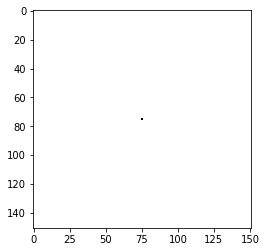

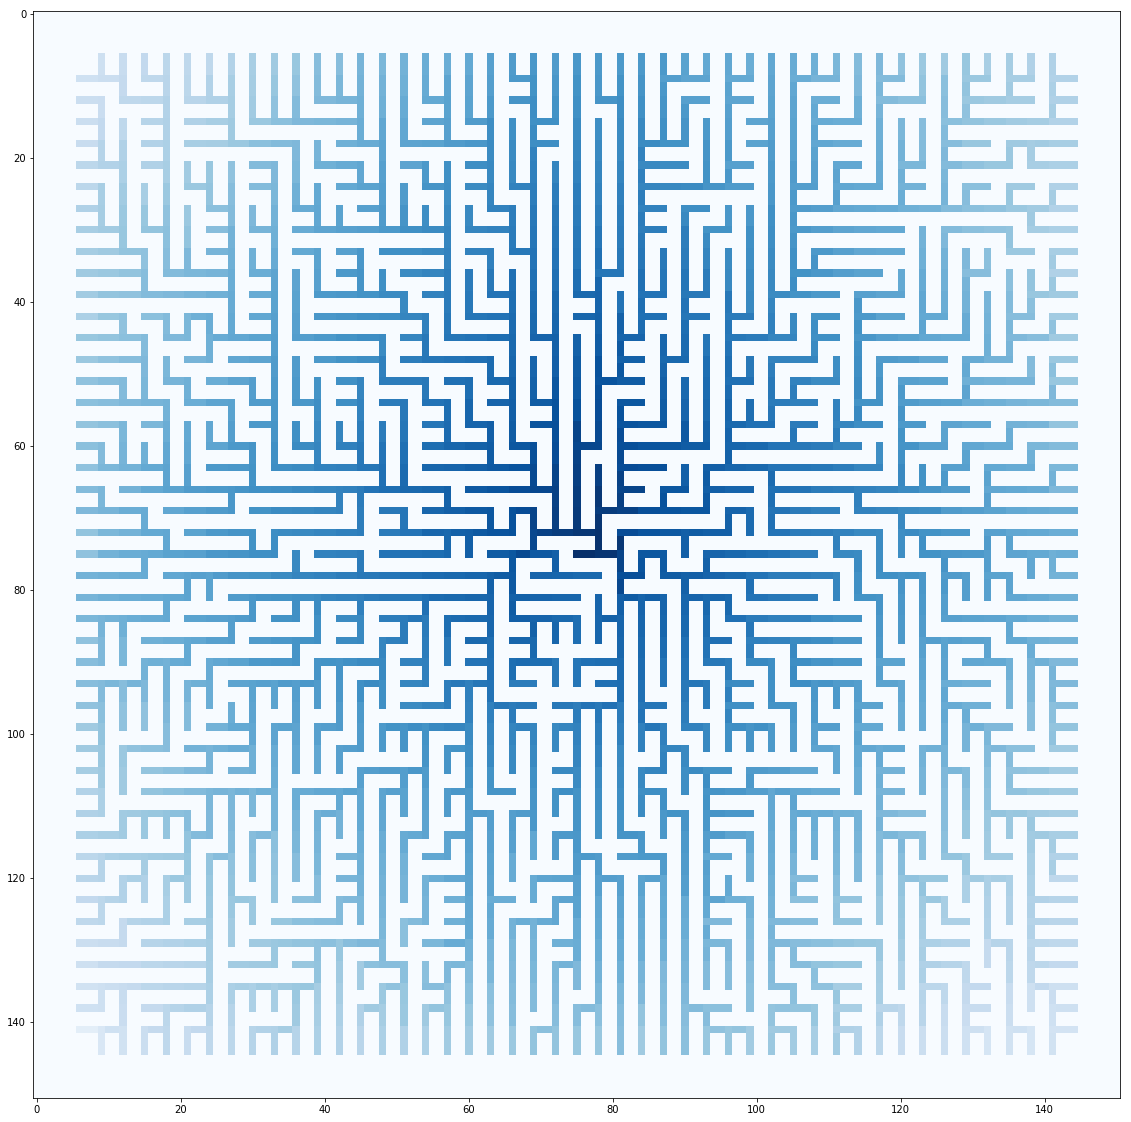

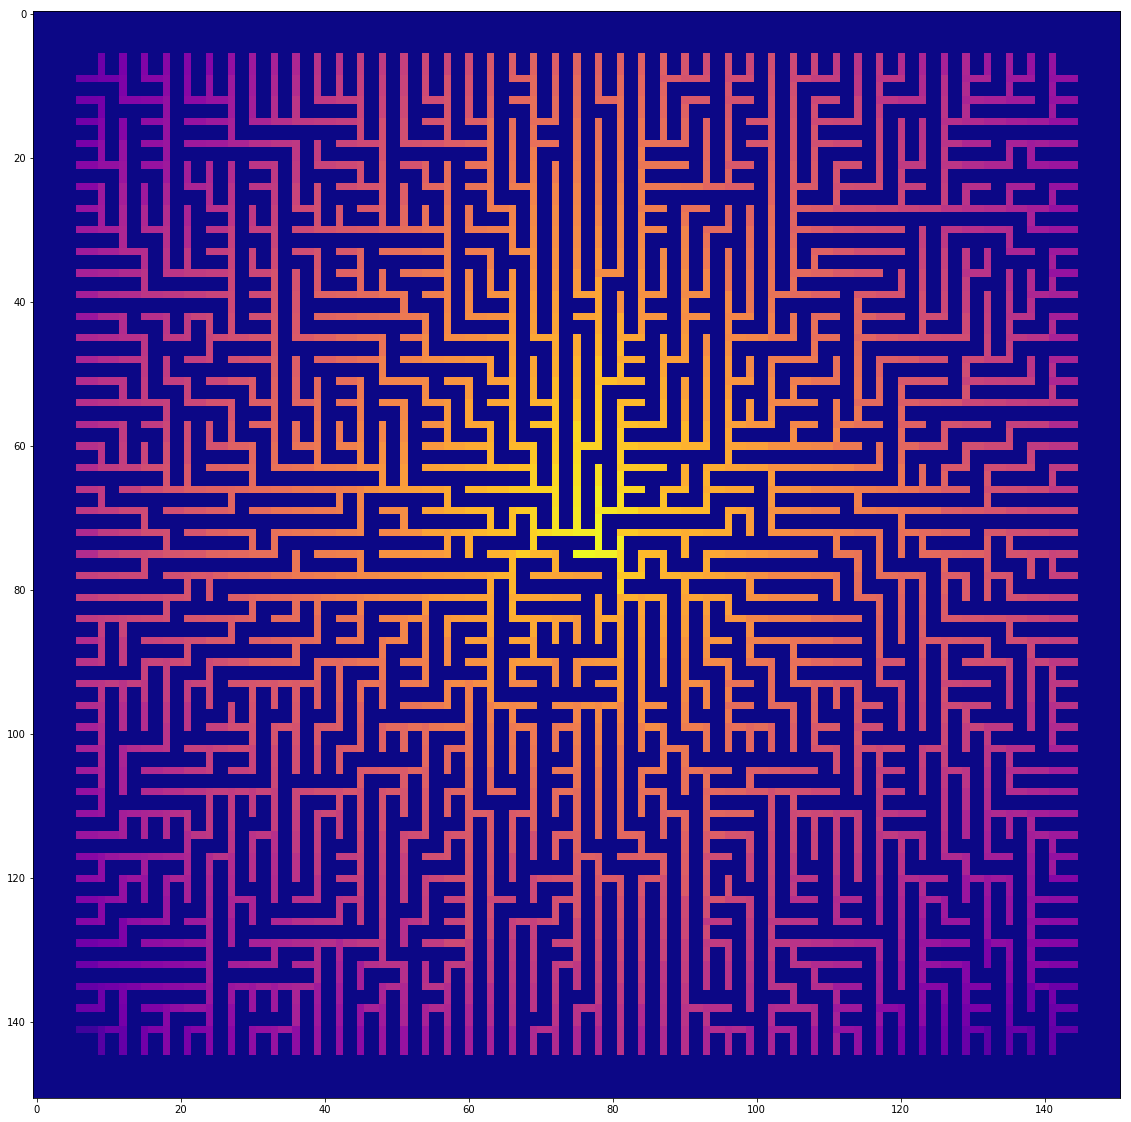

In [81]:
testNest = 0
testNest = StartingNest(startingPositionMatrix_=np.matrix([[0,0,0,1,0,0,0]]), nodeArea_=7, iterations=100, areaX_=151, areaY_=151)
testNest.run()
plt.figure(figsize = (20,20))
plt.imshow(testNest.area, cmap=plt.cm.Blues, interpolation='nearest', aspect='equal')
plt.show()
plt.figure(figsize = (20,20))
plt.imshow(testNest.area, cmap=plt.cm.plasma, interpolation='nearest', aspect='equal')
plt.show()

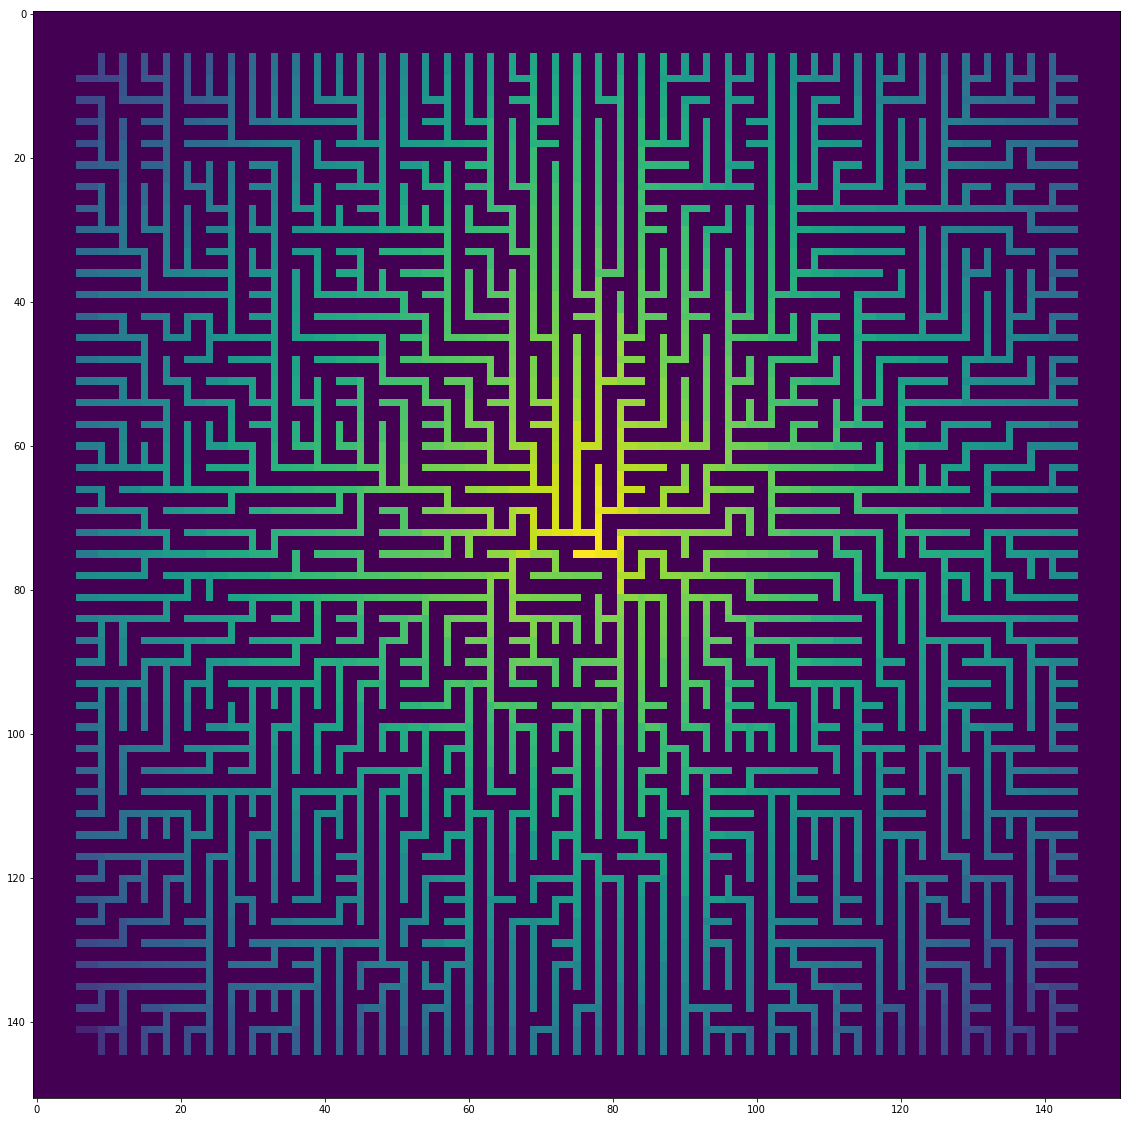

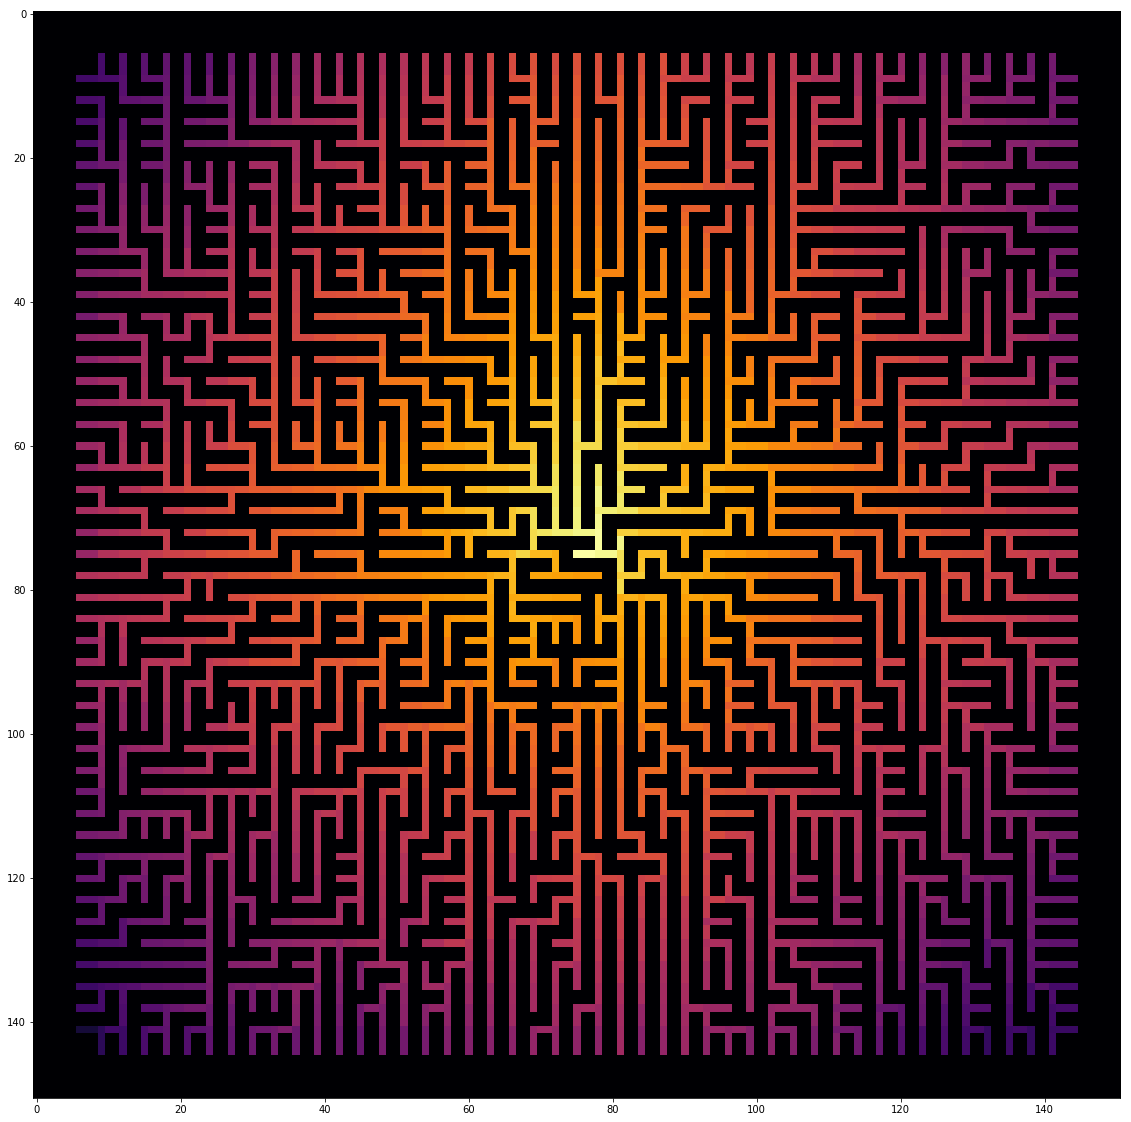

In [82]:
plt.figure(figsize = (20,20))
plt.imshow(testNest.area, cmap=plt.cm.viridis, interpolation='nearest', aspect='equal')
plt.show()
plt.figure(figsize = (20,20))
plt.imshow(testNest.area, cmap=plt.cm.inferno, interpolation='nearest', aspect='equal')
plt.show()

In [78]:
savePattern(filename_="test.png", imgmatrix_=testNest.area, dpi_=300, cmap_=plt.cm.plasma)